## **2- Classification sur la variable "Satisfaction" :**
a. Compléter l'analyse exploratoire de la question 1 en se focalisant sur les relations des différentes variables avec la variable cible.

b.  Prétraiter les données : choisir les variables explicatives (essayer plusieurs sélections), procéder à l'imputation des valeurs manquantes (tester plusieurs stratégies), normaliser les variables, etc.

c.  Appliquer les différents algorithmes étudiés en cours. Pour chacun d'eux on procèdera ainsi : définition d'un dictionnaire d'hyperparamètres, recherche exhaustive (ou aléatoire) des meilleurs hyperparamètres, établissement de la matrice de confusion, calculs des différentes métriques (exactitude, précision, rappel, F1 score, auc, etc.).

d. Comparer les différents algorithmes.

In [1]:
# Imports

from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler
import seaborn as sns
import joblib
import math
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
# from sklearn.neighbors import KNeighborsRegressor, DecisionTreeRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import FunctionTransformer
from sklearn.impute import KNNImputer


### a. Analyse

In [2]:
df = pd.read_csv("df_analysis.csv")

bin_variables = ["Gender", "Customer Type", "Type of Travel" ]
num_variables = [ "Leg room service", "Age", "Flight Distance", "Departure Delay in Minutes", "Arrival Delay in Minutes", "Inflight service", "Inflight wifi service", "On-board service", "Checkin service", "Departure/Arrival time convenient", "Ease of Online booking", "Gate location", "Food and drink", "Online boarding", "Baggage handling", "Seat comfort", "Inflight entertainment", "Cleanliness"]
ord_variables = ["Class"]
targets= ["satisfaction", "Price", "bin_satisfaction"]

#Just for visualization
cat_variables= ["Gender", "Customer Type", "Type of Travel", "Leg room service", "Inflight wifi service", "Inflight service", "Departure/Arrival time convenient", "Ease of Online booking", "On-board service", "Checkin service", "Gate location", "Food and drink", "Online boarding", "Seat comfort", "Inflight entertainment", "Baggage handling", "Cleanliness", "Class"]

#### Variables explicatives catégorielles

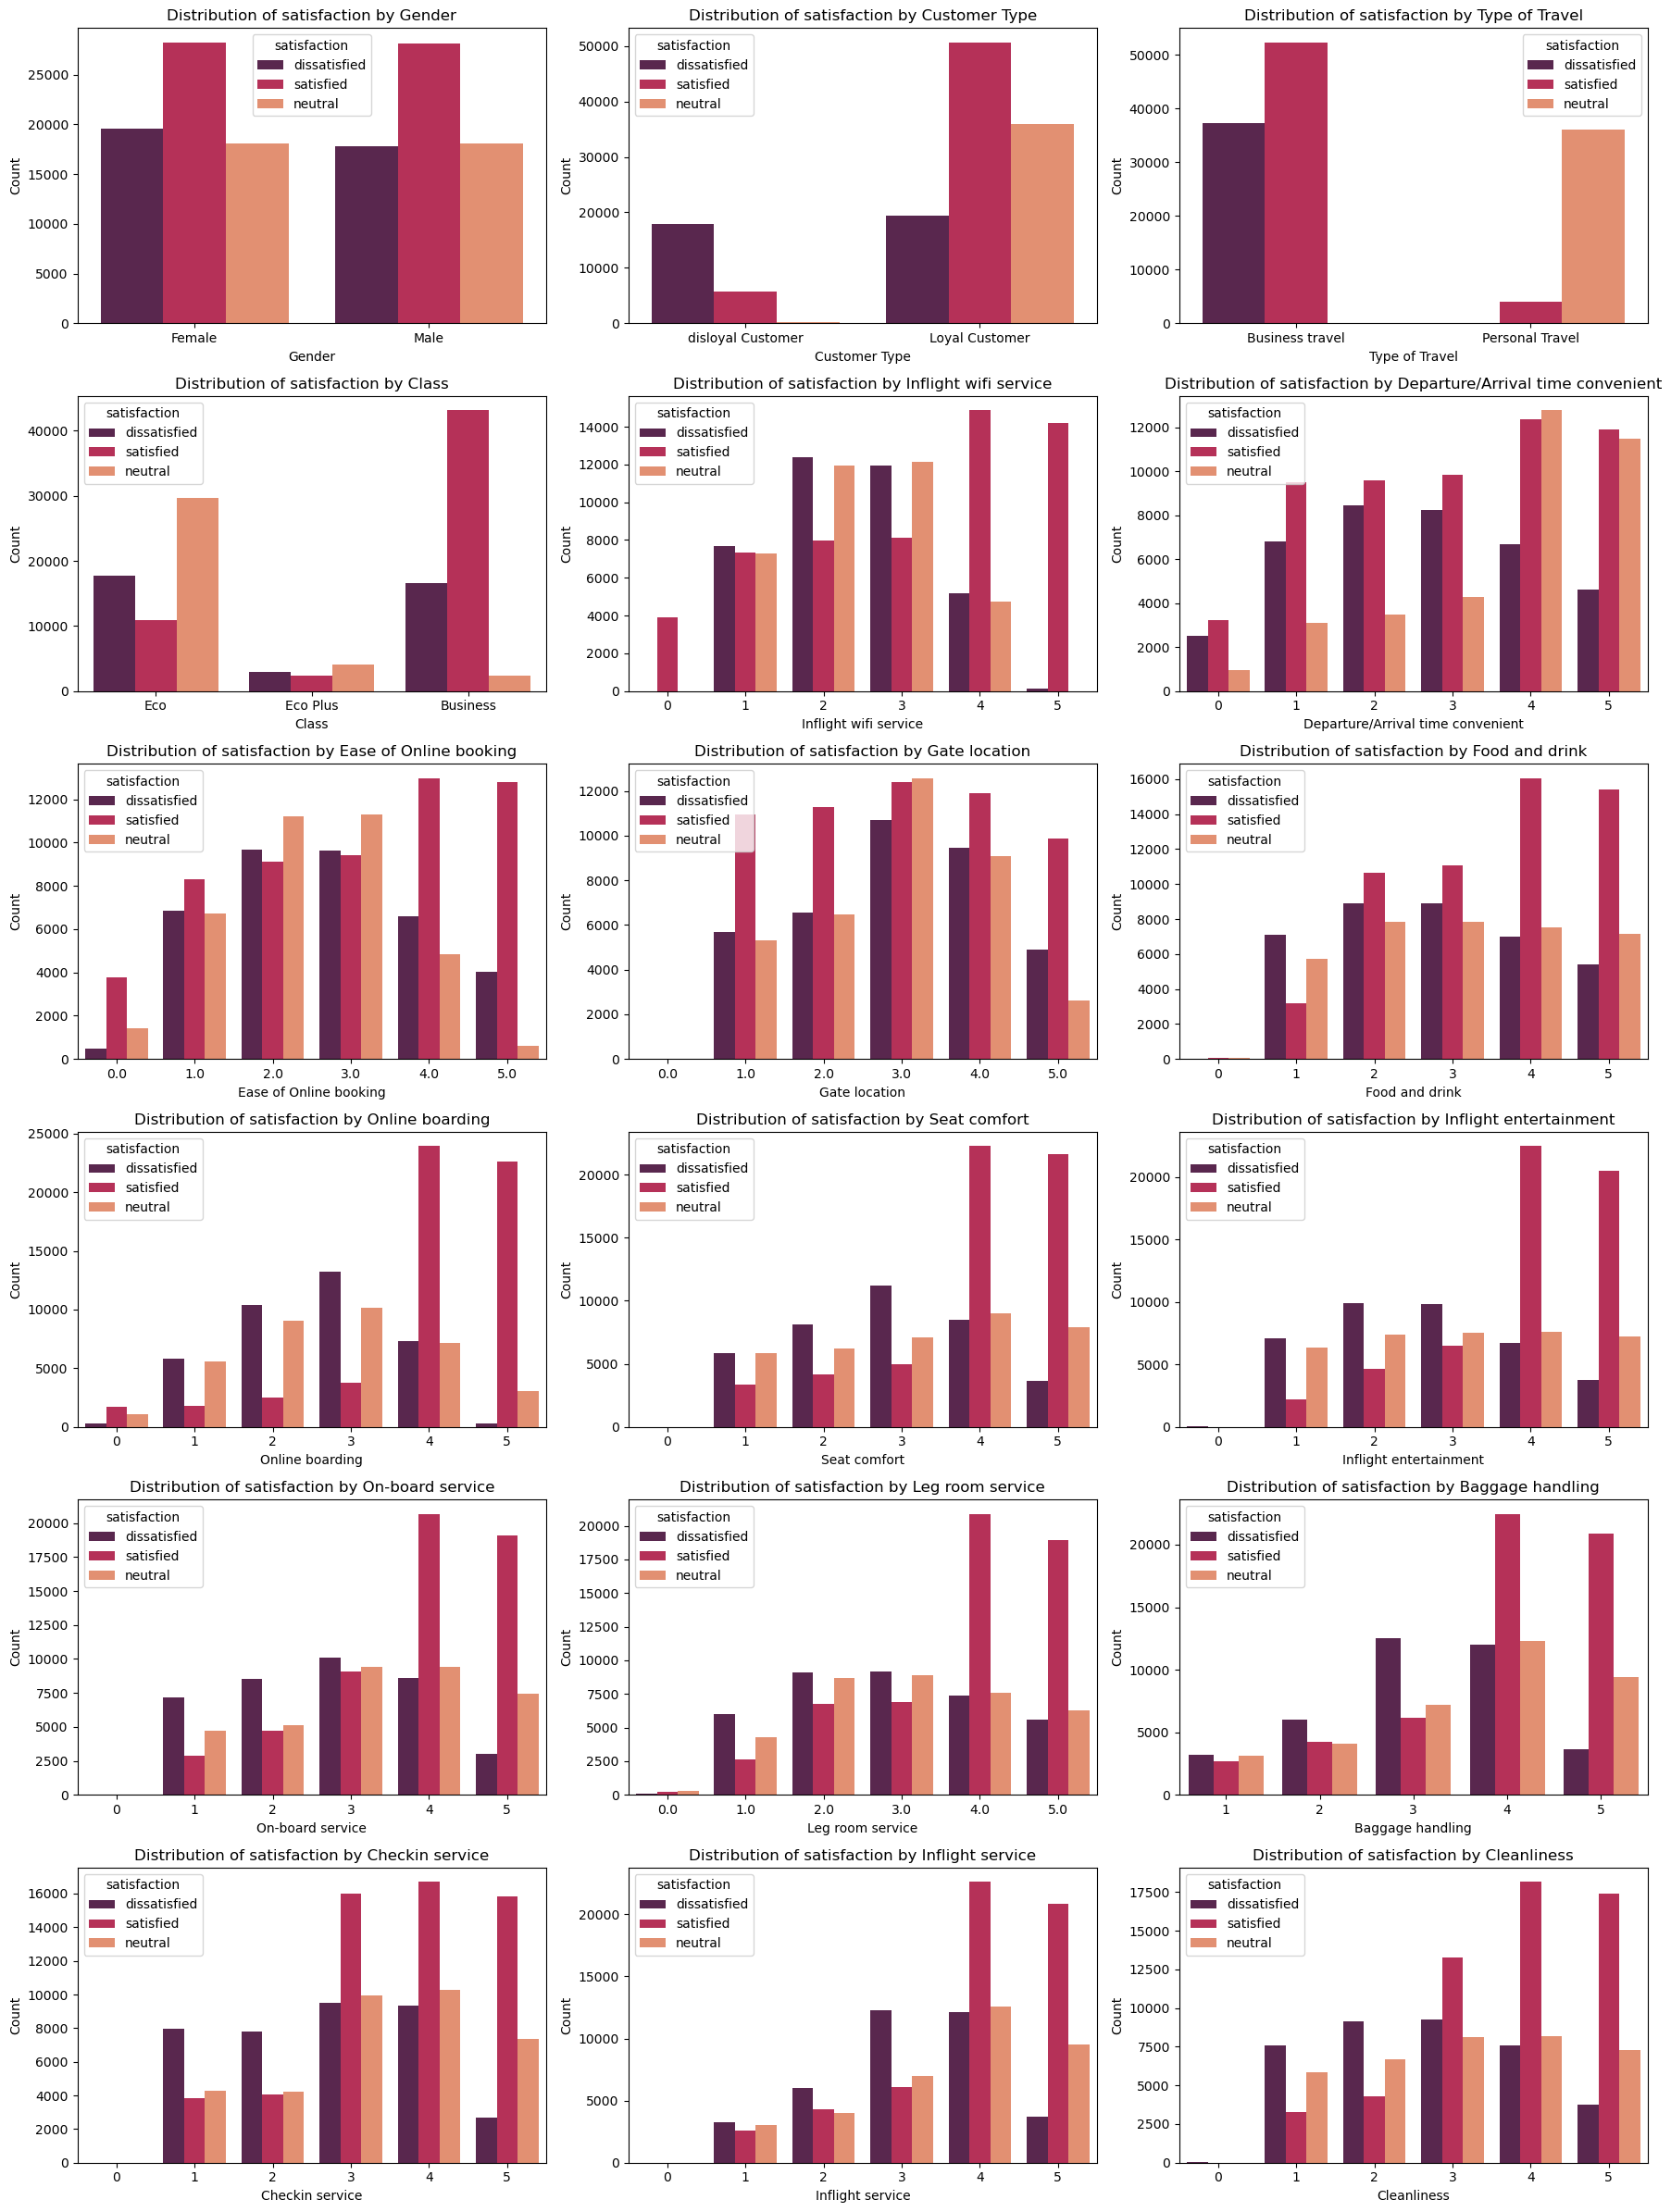

In [3]:
cat_without_targets = [
    col for col in df.columns 
    if col in cat_variables and col not in targets
]

n_cols = 3  # Nombre de graphiques par ligne
n_rows = (len(cat_without_targets) + n_cols - 1) // n_cols  # Calcul du nombre de lignes nécessaires

plt.figure(figsize=(6 * n_cols, 4 * n_rows)) 

for i, var in enumerate(cat_without_targets):
    plt.subplot(n_rows, n_cols, i + 1)  
    sns.countplot(x=var, hue='satisfaction', palette="rocket", data=df)
    plt.title(f'Distribution of satisfaction by {var}')
    plt.xlabel(var)
    plt.ylabel('Count')

plt.tight_layout() 

### Variables explicatives numériques

/var/folders/1k/1sj3zxpx1x78x8blphwrrcrc0000gn/T/ipykernel_7068/4120679127.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[df['satisfaction'] == 'satisfied'][col], label='Satisfied', shade=True)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/1k/1sj3zxpx1x78x8blphwrrcrc0000gn/T/ipykernel_7068/4120679127.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[df['satisfaction'] == 'neutral'][col], label='Neutral', shade=True)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Fut

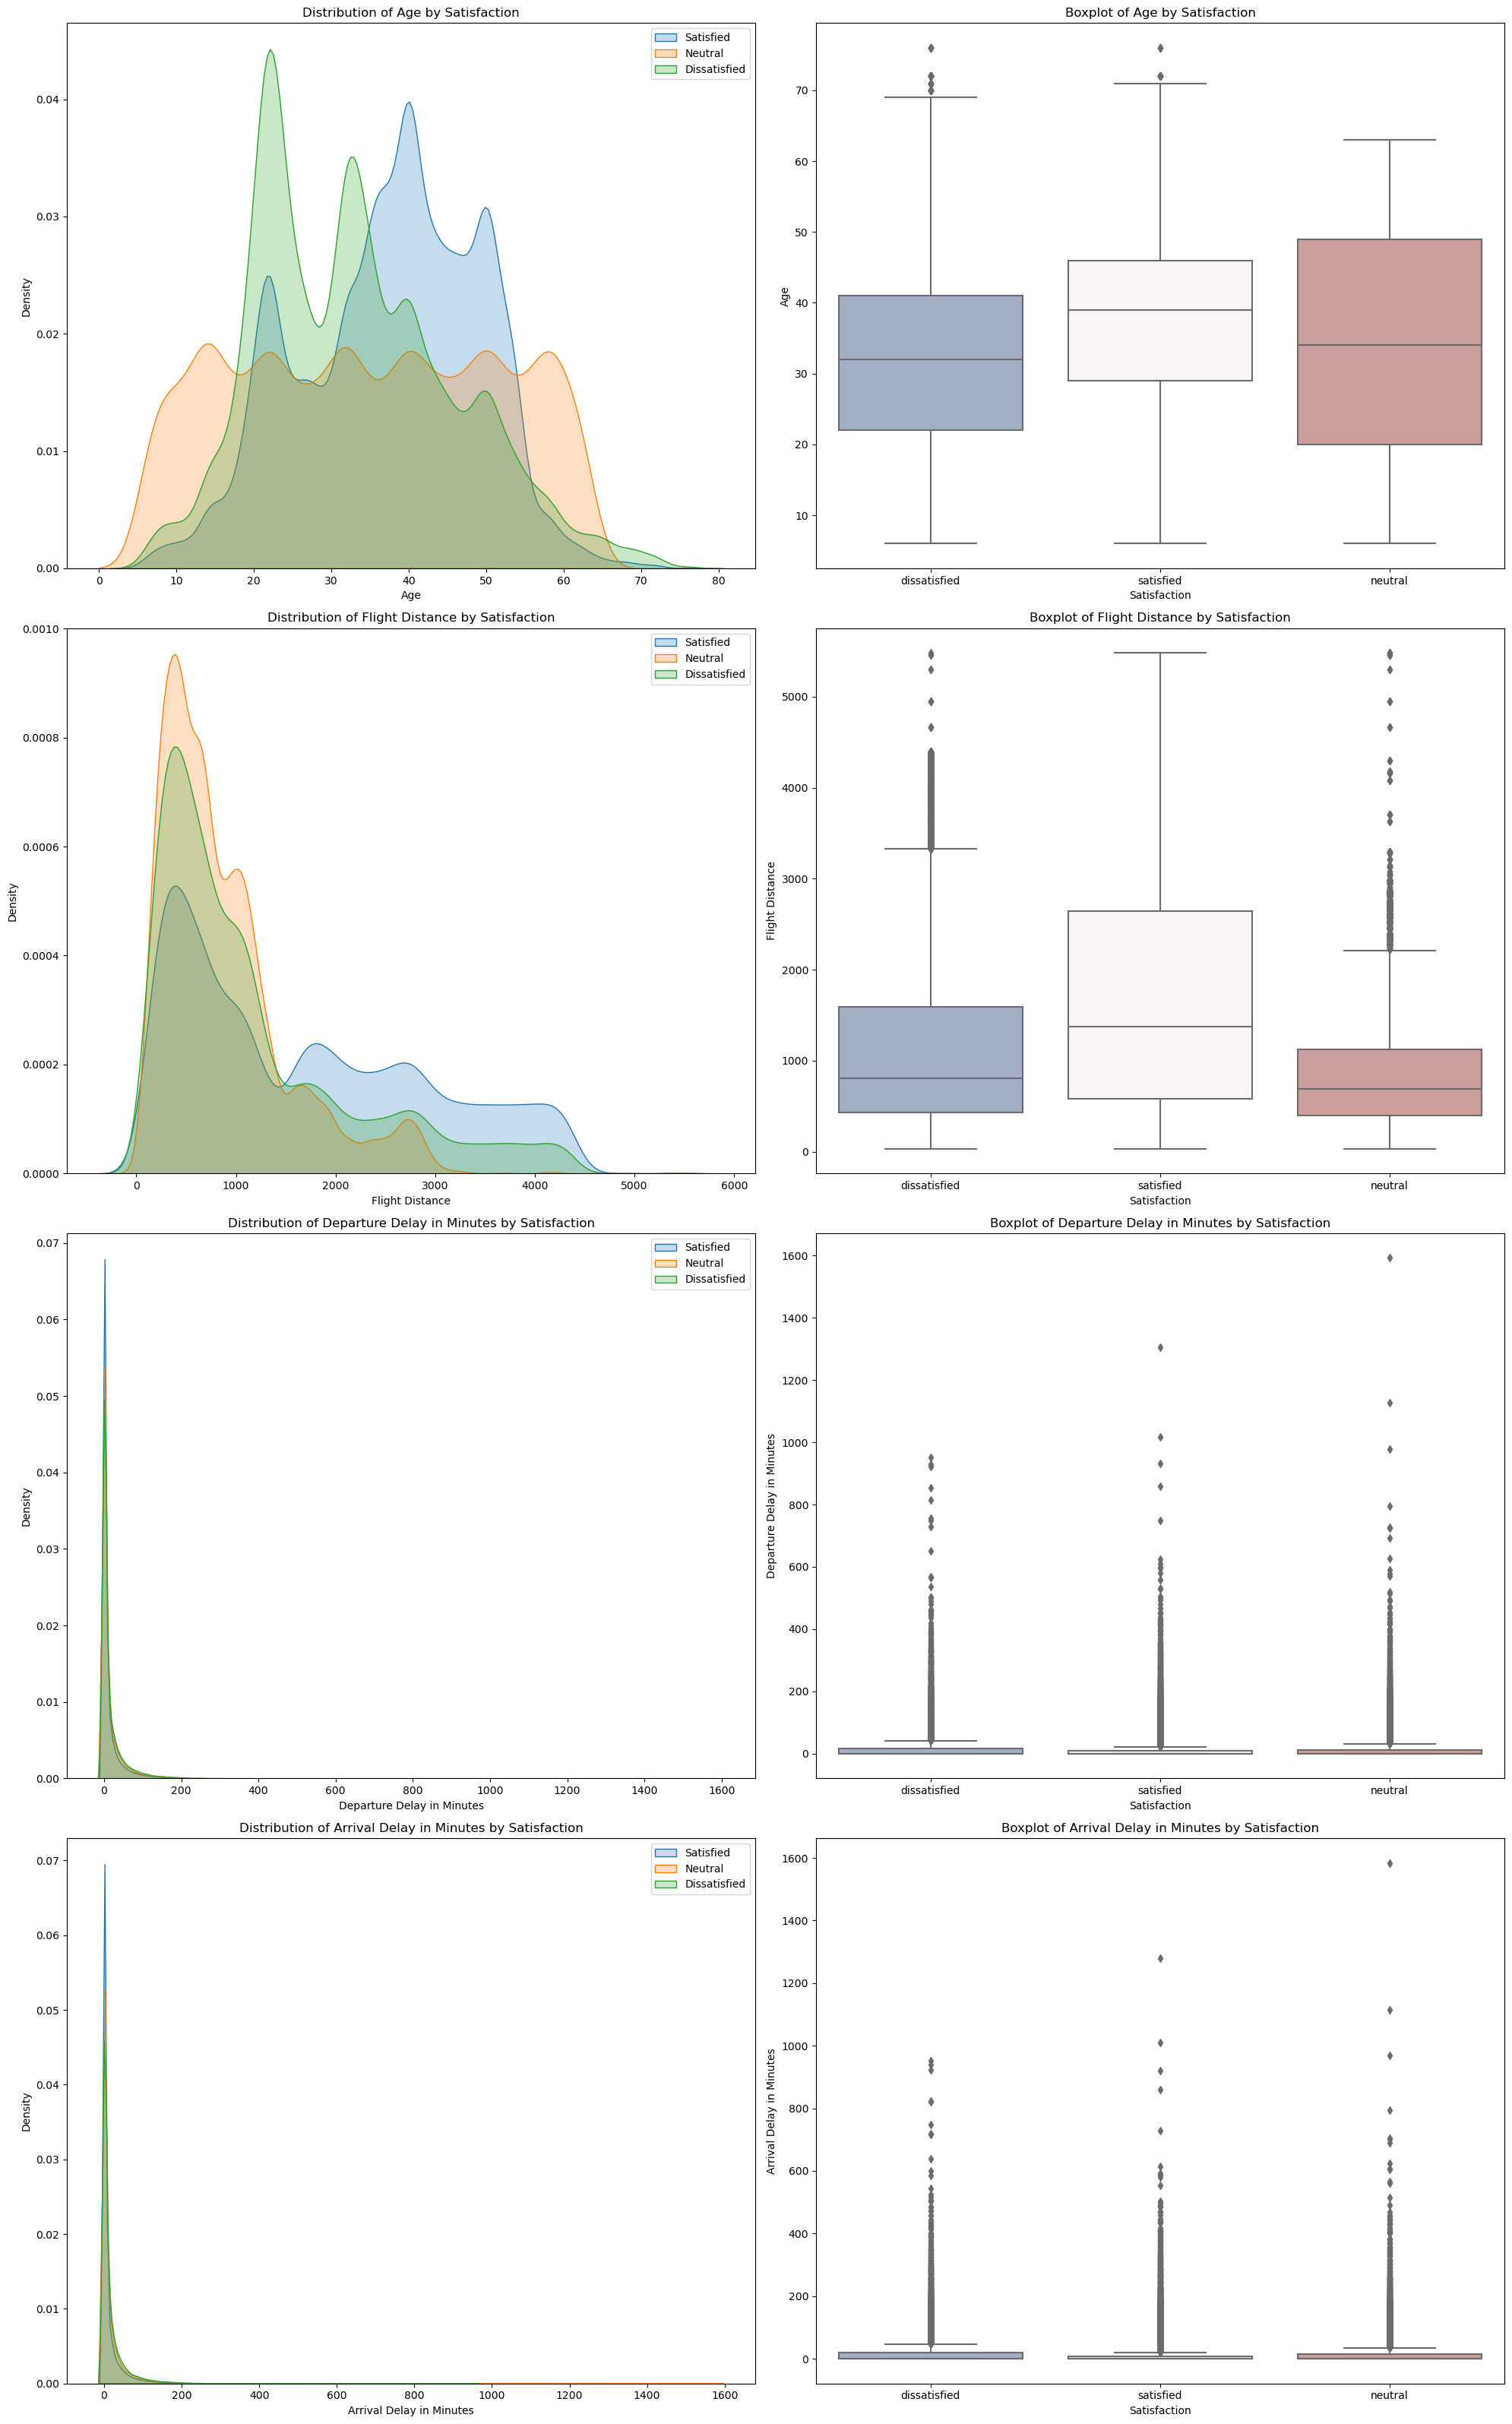

In [4]:
no_cat_variables = [
    col for col in df.columns 
    if col not in cat_variables and col not in targets
]

# Configuration de la mise en page du subplot
n_cols = 2
n_rows = (len(no_cat_variables) + n_cols - 1) // n_cols * 2  # Multiplié par 2 pour inclure les boxplots

plt.figure(figsize=(10 * n_cols, 8 * n_rows))  # Ajustement de la taille pour mieux s'adapter aux deux types de plots

for i, col in enumerate(no_cat_variables):
    # Tracé des graphiques de densité
    plt.subplot(n_rows, n_cols, 2 * i + 1)  # 2 * i + 1 pour laisser de la place pour les boxplots en dessous de chaque kdeplot
    sns.kdeplot(data=df[df['satisfaction'] == 'satisfied'][col], label='Satisfied', shade=True)
    sns.kdeplot(data=df[df['satisfaction'] == 'neutral'][col], label='Neutral', shade=True)
    sns.kdeplot(data=df[df['satisfaction'] == 'dissatisfied'][col], label='Dissatisfied', shade=True)
    plt.title(f'Distribution of {col} by Satisfaction')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()

    # Ajout de boxplots sous chaque graphique de densité
    plt.subplot(n_rows, n_cols, 2 * i + 2)  # 2 * i + 2 pour les boxplots juste en dessous des kdeplots
    sns.boxplot(x='satisfaction', y=col, data=df, palette="vlag")
    plt.title(f'Boxplot of {col} by Satisfaction')
    plt.xlabel('Satisfaction')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

D'après ces graphqiues des variables explicatives en fonction de la satisfaction, on voit que :
- les clients plus jeunes ont tendance à être légèrement moins satisfaits que les plus âgés. Les personnes plus âgées ont tendance à avoir un avis plus neutre.
- les clients les plus satisfaits ont l'air d'être ceux faisant de plus grandes distance de vol.

Les variables "Departure Delay in Minutes" et "Arrival Delay in Minutes" ne semblent pas avoir un impact sur la satistfaction des clients. Les nombreuses valeurs extrèmes ne semblent pas être des anomalies. Elles semblent totalement en adéquation avec la distribution (voir courbes) et logiques.

### b. Prétraitement

In [5]:
df = pd.read_csv("project.csv")

#### Supprimer les colonnes inutiles

In [6]:
variables_to_remove = ["Unnamed: 0", "id"]

df = df.drop(variables_to_remove, axis=1)

df.dtypes

Gender                                object
Customer Type                         object
Age                                  float64
Type of Travel                        object
Class                                 object
Flight Distance                      float64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking               float64
Gate location                        float64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                     float64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
satisfacti

#### Nombre de valeurs nulles

In [7]:
print("🚀 ~ df:")
print(df.shape)
print("null_values:", df.isnull().values.sum())
print("null_values by column:", df.isnull().sum())

# print(df.head)

🚀 ~ df:
(129880, 24)
null_values: 913
null_values by column: Gender                                 0
Customer Type                          0
Age                                  126
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking               131
Gate location                        130
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                     133
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
satisfaction                         

Il faudra faire une imputation.

#### Formater les variables binaires (pipeline)
Comme elles ne sont pas sous la forme d'un boolean, on remplace chacune des 2 valeurs par 0 ou 1.

In [8]:
def set_bin_num(df):
    # Création d'un nouveau DataFrame pour les résultats
    result = df.copy()
    conditions = [
        (df['Gender'] == "Male") | (df['Customer Type'] == "disloyal Customer") | (df['Type of Travel'] == "Personal Travel")
    ]
    # Utiliser np.select pour assigner 0 ou 1 selon les conditions
    result['Gender'] = np.select(conditions, [0], default=1)
    result['Customer Type'] = np.select(conditions, [0], default=1)
    result['Type of Travel'] = np.select(conditions, [0], default=1)
    
    return result[['Gender', 'Customer Type', 'Type of Travel']]


In [9]:
bin_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", FunctionTransformer(set_bin_num, validate=False))
    ]
)

#### Formater les variables ordinales (pipeline)

In [10]:
# Transforme les strings en nombres qui sont ordonnés entre eux

satisfaction_pipeline = Pipeline(steps=[
  ("imputer", SimpleImputer(strategy="most_frequent")),
  ("satisfaction_encoder", OrdinalEncoder(categories=[["dissatisfied", "neutral", "satisfied"]]))
])

class_pipeline = Pipeline(steps=[
  ("imputer", SimpleImputer(strategy="most_frequent")),
  ("class_encoder", OrdinalEncoder(categories=[["Eco", "Eco Plus", "Business"]])),
])

#### Formater les variables numériques (pipeline)
Comme les variables numériques ne suivent pas une loi normale, on doit normaliser avec le min et le max (et non avec le standardScaler)

In [11]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, columns, factor = 1.5, remove=True):
        self.columns = columns
        self.factor = factor
        self.remove = remove
        self.kept_indices = None
        
    def remove_outliers(self, X):
        l = []
        for c in self.columns:
            Q1 = X[c].quantile(0.25)
            Q3 = X[c].quantile(0.75)
            delta = Q3-Q1
            lower_bound = Q1 - self.factor*delta
            upper_bound = Q3 + self.factor*delta
            column = X[c].loc[ ( (X[c] >= lower_bound) & (X[c] <= upper_bound) )  ]
            l.append( pd.Series(column) )
            
        res = pd.concat(l, axis=1, join = "inner")
        
        self.kept_indices = res.index
        
        return X.loc[self.kept_indices]
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.remove:
            return self.remove_outliers(X)
        else:
            self.kept_indices = X.index
            return X

outlier_pipeline = Pipeline(steps = [("outliers", OutlierRemover(columns=df.drop(columns='satisfaction', axis=1).columns, factor=1.5, remove=False))])

In [12]:
num_pipeline = Pipeline(steps=[
  ('imputer', KNNImputer()),
  ("scaler", MinMaxScaler())
])

#### Définition de la pipeline dans l'ordre

In [13]:
preprocessor = ColumnTransformer(transformers=[
    ("class", class_pipeline, ["Class"]),
    ("satisfaction", satisfaction_pipeline, ["satisfaction"]),
    ("bin", bin_pipeline, bin_variables),
    ("num", num_pipeline, num_variables)
], remainder="passthrough", verbose_feature_names_out=False)  # Correction: retirer `verbose = 4,` qui est mal placé et incorrect

preprocessor.set_output(transform='pandas')


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('class',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('class_encoder',
                                                  OrdinalEncoder(categories=[['Eco',
                                                                              'Eco '
                                                                              'Plus',
                                                                              'Business']]))]),
                                 ['Class']),
                                ('satisfaction',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('satisfaction_encoder',
                                                  OrdinalEncoder(cat...
                                 ['Leg room service', 'Age', 'Flight Distance',
                                  'Departure Delay in Minutes',
                                  'Arrival Delay in Minutes',
                                  'Inflight service', 'Inflight wifi service',
                                  'On-board service', 'Checkin service',
                                  'Departure/Arrival time convenient',
                                  'Ease of Online booking', 'Gate location',
                                  'Food and drink', 'Online boarding',
                                  'Baggage handling', 'Seat comfort',
                                  'Inflight entertainment', 'Cleanliness'])],
                  verbose_feature_names_out=False)

In [14]:
pipeline = Pipeline([
    ("outlier_remover", outlier_pipeline),
    ("preprocessor", preprocessor)
])

df_clean = pipeline.fit_transform(df)

#### Découpage du dataset en datasets d'entrainement et de test

In [15]:
X = df_clean.drop(["satisfaction"], axis=1)
y = df_clean["satisfaction"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=314)

### c.  Appliquer les différents algorithmes étudiés en cours. Pour chacun d'eux on procèdera ainsi : définition d'un dictionnaire d'hyperparamètres, recherche exhaustive (ou aléatoire) des meilleurs hyperparamètres, établissement de la matrice de confusion, calculs des différentes métriques (exactitude, précision, rappel, F1 score, auc, etc.). -> Classification multi

Doc: https://scikit-learn.org/stable/modules/multiclass.html

In [16]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import time


# Définition des modèles pour le VotingClassifier
log_clf = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)
tree_clf = DecisionTreeClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

# VotingClassifier & AdaBoostClassifier
estimators = [
    ('lr', log_clf), 
    ('tree', tree_clf), 
    ('svc', svm_clf)
]

# GaussianNB
delta = 5*1e-10
var_smoothing_start = 1e-9 - delta
var_smoothing_end = 1e-9 + delta
var_smoothing_step = 1e-11

# LDA
start_shrinkage = 0.1
end_shrinkage = 0.3
step_shrinkage = 0.001


# * Définition du dictionnaire d'hyperparamètres
models_dict = [
   # 0
               {
                  "type": KNeighborsClassifier(), 
                  "hyperparameters" : []
                  },
   # 1
               {
                  "type": KNeighborsClassifier(), 
                  "hyperparameters" : [
                     {
                          "n_neighbors" : [3, 5, 10],
                          "weights"     : ["uniform", "distance"],
                        #   "algorithm"   : ["ball_tree", "kd_tree"],
                        #   "p"           : [2, 6, 10],
                      }
                    ]
                },
   # 2
               {"type": DecisionTreeClassifier(), "hyperparameters" : []},
   # 3
               {
                  "type": DecisionTreeClassifier(), 
                  "hyperparameters" : [
                     {
                        'criterion': ['gini', 'entropy'],
                        'max_depth': [3, 5, 10],
                      }
                    ]
                },
   # 4
               {"type": GaussianNB(), "hyperparameters" : []},
   # 5
               {
                  "type": GaussianNB(), 
                  "hyperparameters" : [
                     {
                        "var_smoothing" : np.arange(var_smoothing_start, var_smoothing_end, var_smoothing_step)
                      }
                  ]
               },
   # 6
               {"type": LinearSVC(multi_class="crammer_singer", max_iter=5000, dual=True), "hyperparameters" : []}, # not converge even with 100k iter
   # 7
               {"type": RandomForestClassifier(), "hyperparameters" : []},  
   # 8
               {
                  "type": VotingClassifier(estimators=estimators, voting='hard'), 
                  "hyperparameters" : [
                     # {
                     #  'lr__C': [0.1, 1.0],
                     #  'tree__criterion': ['gini', 'entropy'],
                     #  'tree__max_depth': [3, 4, 5],
                     #  'svc__C': [0.1, 1.0],
                     #  'svc__gamma': ['scale', 'auto'],
                     # }
                  ]
                },  
   # 9
               {
                  "type": AdaBoostClassifier(), 
                  "hyperparameters" : [
                     {
                        "n_estimators" : [50, 100, 200],
                        "learning_rate": [0.1, 1, 10]
                     }
                  ]
               },
   # 10
               {"type": GradientBoostingClassifier(), "hyperparameters" : []},
   # 11
               {
                     "type": GradientBoostingClassifier(), 
                     "hyperparameters" : [
                        {
                        #    "n_estimators" : [50, 100, 200],
                        #    "learning_rate": [0.1, 1, 10],
                           "criterion": ["friedman_mse", "squared_error"],
                        #    "max_depth": [3, 5, 10]
                        }
                     ]
                  },
   # 12
               {"type": LinearDiscriminantAnalysis(), "hyperparameters" : []},
   # 13
               {
                  "type": LinearDiscriminantAnalysis(), 
                  "hyperparameters" : [
                     {
                        "solver" : ["lsqr", "eigen"],
                        # "shrinkage": np.arange(start_shrinkage, end_shrinkage, step=step_shrinkage),
                     },
                     {
                        "solver" : ["svd"],
                     }
                  ]
               },   
               # {"type": LogisticRegression(multi_class="multinomial", max_iter=1000), "hyperparameters" : []},
              ]

# Initialiser le dictionnaire pour les scores
model_scores = {}

for index, model in enumerate(models_dict):
    classifier = model["type"]
    best_params = {}
    model_name=f"{type(classifier).__name__}"
    print("Calculating: ", index)
    start_time = time.time()

    if model["hyperparameters"] == []:
      # * Essai avec le modèle pur
      classifier.fit(X_train.values, y_train.values.ravel())
      y_pred = classifier.predict(X_test.values)
    else:
      # * Recherche des meilleurs hyperparamètres
      model_name += "_gscv"
      hyperparameters = model["hyperparameters"]
      gscv_model = GridSearchCV(
      estimator = classifier,
      param_grid = hyperparameters,
      cv = 5,
      scoring = "f1_weighted")
      gscv_model.fit(X_train.values, y_train.values.ravel())
      y_pred = gscv_model.predict(X_test.values)
      best_params = gscv_model.best_params_
      
    end_time = time.time()
    fit_time = math.trunc(end_time - start_time)
    print(fit_time, "secondes")

    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    
    # Stocker les métriques
    model_scores[model_name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": cm,
        "best_params": best_params
    }

Calculating:  0


1 secondes
Calculating:  1
34 secondes
Calculating:  2
1 secondes
Calculating:  3
11 secondes
Calculating:  4
0 secondes
Calculating:  5
25 secondes
Calculating:  6


In [ ]:
for model_name, model_info in model_scores.items():
    print("Name: ", model_name)
    print("--> best_params: ", model_info['best_params'])
    print("--> accuracy: ", model_info['accuracy'])
    print("--> precision: ", model_info['precision'])
    print("--> recall: ", model_info['recall'])
    print("--> f1_score: ", model_info['f1_score'])
    print("--> confusion_matrix: \n", model_info['confusion_matrix'])
    print("---------------------------------------")

Name:  KNeighborsClassifier
--> best_params:  {}
--> accuracy:  0.8229904527255929
--> precision:  0.8278715427670041
--> recall:  0.8229904527255929
--> f1_score:  0.8247596715704907
--> confusion_matrix: 
 [[ 5900  1179   391]
 [ 1483  5457   281]
 [  738   526 10021]]
---------------------------------------
Name:  KNeighborsClassifier_gscv
--> best_params:  {'n_neighbors': 10, 'weights': 'distance'}
--> accuracy:  0.8305743763473976
--> precision:  0.8338018492001351
--> recall:  0.8305743763473976
--> f1_score:  0.8318404062300577
--> confusion_matrix: 
 [[ 5904  1130   436]
 [ 1370  5561   290]
 [  640   535 10110]]
---------------------------------------
Name:  DecisionTreeClassifier
--> best_params:  {}
--> accuracy:  0.862026485987065
--> precision:  0.8619454008507667
--> recall:  0.862026485987065
--> f1_score:  0.8619845055220229
--> confusion_matrix: 
 [[ 5989   951   530]
 [ 1007  5920   294]
 [  482   320 10483]]
---------------------------------------
Name:  DecisionTree

### 4. Comparer les différents algorithmes.

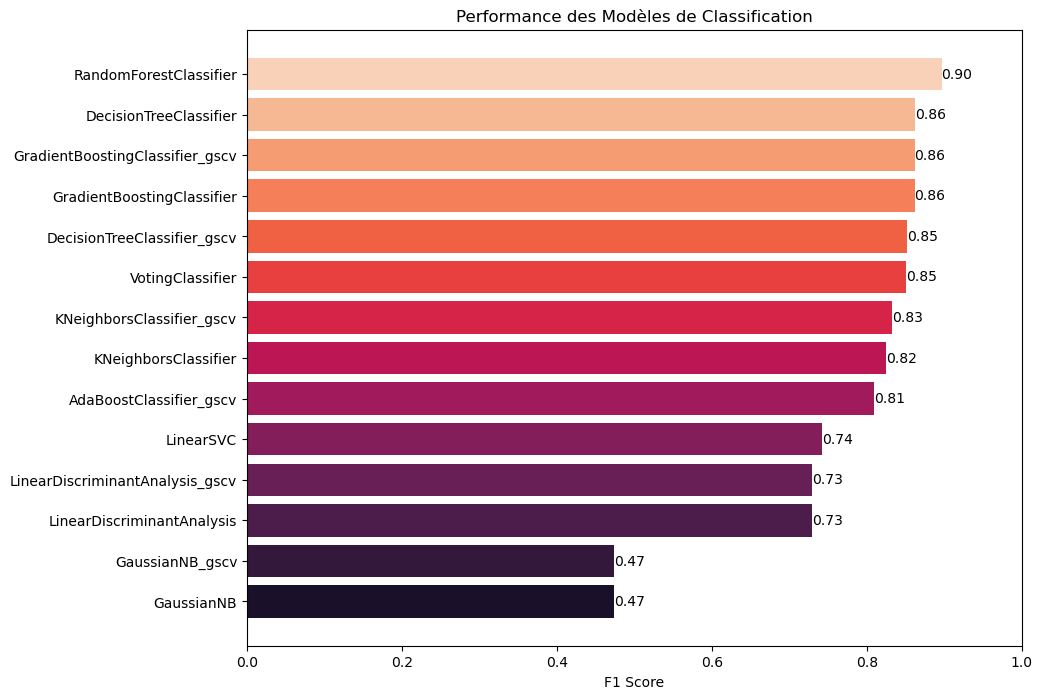

In [ ]:
# Tri du dictionnaire par score F1
sorted_scores = dict(sorted(model_scores.items(), key=lambda item: item[1]['f1_score']))

colors = sns.color_palette('rocket', len(sorted_scores))

# Tracer le graphique
plt.figure(figsize=(10, 8))
bars = plt.barh(list(sorted_scores.keys()), [info['f1_score'] for info in sorted_scores.values()], color=colors)
plt.xlabel('F1 Score')
plt.title('Performance des Modèles de Classification')
plt.xlim(0, 1)  # Limiter l'axe des x pour mieux visualiser les scores F1

# Ajouter les valeurs exactes sur les barres
for bar in bars:
    plt.text(bar.get_width(),  # Position horizontale, un peu à droite de la fin de la barre
             bar.get_y() + bar.get_height() / 2,  # Position verticale, au centre de la barre
             f'{bar.get_width():.2f}',  # Texte avec 2 décimales
             va='center',  # Alignement vertical au centre
             ha='left')  # Alignement horizontal à gauche pour que le texte suive la barre

plt.show()